<a href="https://colab.research.google.com/github/vzinkovski/financial-data-science/blob/main/commodities_mean_reversion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CME Corn/Wheat Mean Reversion Trading Strategy

In it's most simple form, all trading strategies can be classified as either momentum or mean reversion. Commodities are often fungible, that is interchangeable to a certain degree. This in turn implies both a positive correlation, as well as cointegration, between a select number of commodity pairs. This project will explore a mean reverting pairs trading strategy between CME corn and SRW wheat futures applied to the continuous futures front month contract.

### Import libraries

In [1]:
# standard libraries
from datetime import datetime, timedelta
import numpy as np
import pandas as pd

# financial analysis
import yfinance as yf #Yahoo! Finance API
from statsmodels.tsa.stattools import adfuller

# plotting
import matplotlib.pyplot as plt
import seaborn as sns

### Fetching price data

In [2]:
# user specified time range
start = '2022-01-01'
end = datetime.now() - timedelta(1)

# commodity pairs
commodities = {'srw':'ZW=F', 'hrw':'KE=F', 'corn':'ZC=F', 'soybeans':'ZS=F', # agri
               'wti':'BZ=F', 'brent':'CL=F', # energy
               }

# function to fetch price from Yahoo! Finance
def get_prices(commodities, start, end):
    """Fetch historical financial data for specified period from Yahoo! Finance API
    
    Parameters
    ----------
    commodities : dictionary
        commodity names (keys) and corresponding tickers (value)
    start : string
        start date (inclusive) in YYYY-MM-DD format
    end : string
        end date (inclusive) in YYYY-MM-DD format
        
    Returns
    -------
    data : pandas.DataFrame
        a multilevel column DataFrame containing OHLC, Adj Close, Volume for each commodity
    """

    ticker_list = ''
    for name, ticker in commodities.items():
        ticker_list = ticker_list + ticker + " "
    data = yf.download(ticker_list, start=start, end=end)
    return data

# fetching price data
prices = get_prices(commodities, start, end)
closing_prices = prices['Adj Close'].fillna(method='ffill')

[*********************100%***********************]  6 of 6 completed


### Plotting commodity pairs price correlation

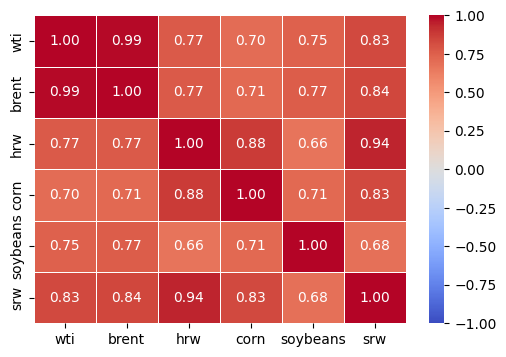

In [3]:
# swap key/value for each dict entry in order to show
# verbose commodity description rather than ticker
columns = dict((v,k) for k,v in commodities.items())
closing_prices = closing_prices.rename(columns=columns)

# plot heatamp
plt.subplots(figsize=(6,4))
sns.heatmap(closing_prices.corr(), annot=True, cmap='coolwarm',
            linewidths=0.5, vmin=-1, vmax=1, fmt='.2f');

### Making the series stationary

In order to implement a mean reverting strategy we first have to ensure our data is stationary, which simply means a constant mean and variance. A simple test is a quick visual inspection, however a more robust statistical test is the Augmented Dicky-Fuller (ADF) test. A typical $a$ is 0.05 and we reject the null hypothesis, i.e. our data is stationary, when our p-value is below this threshold.

#### CME corn/wheat price ratio

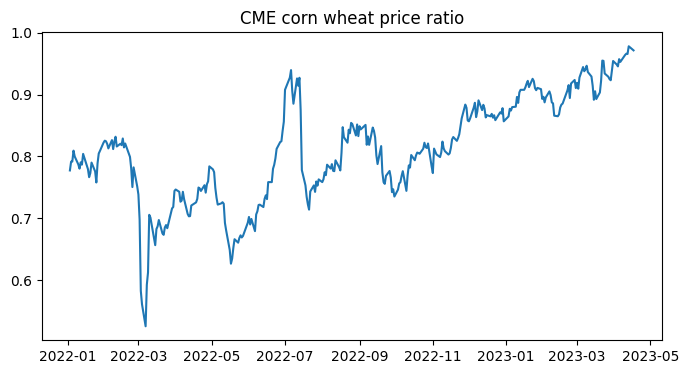

ADF statistic:
-1.767860 

p-value: 
0.396531 

Critical values:
1% @ -3.451
5% @ -2.871
10% @ -2.572


In [8]:
# calculate ratio
ratio = closing_prices['corn'] / closing_prices['srw']

# plot ratio
plt.subplots(figsize=(8, 4))
plt.plot(ratio.index, ratio)
plt.title('CME corn wheat price ratio')
plt.show()

# checking for stationarity
result = adfuller(ratio)
print('ADF statistic:\n%f' % result[0], '\n')
print('p-value: \n%f' % result[1], '\n')
print('Critical values:')
for key, value in result[4].items():
  print('%s @ %.3f' % (key, value))

#### CME corn/wheat price ratio log returns

In order to make our series stationary we perform a log transformation followed by differencing $t$ and $t_{-1}$, which gives us log returns.

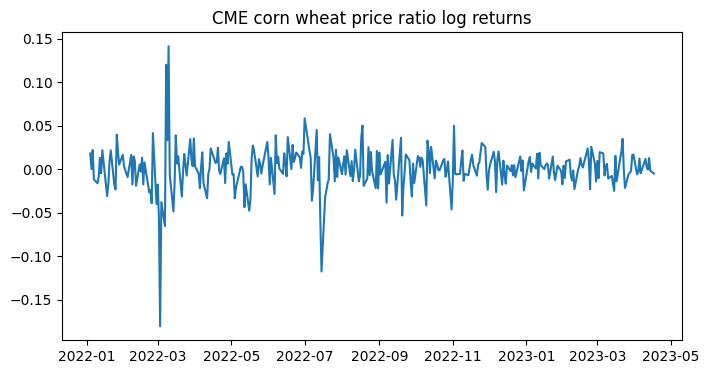

ADF statistic:
-10.011564 

p-value: 
0.000000 

Critical values:
1% @ -3.451
5% @ -2.871
10% @ -2.572


In [14]:
# calculate log returns
ratio_log_returns = np.log(ratio).diff().dropna()

# plot log returns
plt.subplots(figsize=(8, 4))
plt.plot(ratio_log_returns.index, ratio_log_returns)
plt.title('CME corn wheat price ratio log returns')
plt.show()

# checking for stationarity
result = adfuller(ratio_log_returns)
print('ADF statistic:\n%f' % result[0], '\n')
print('p-value: \n%f' % result[1], '\n')
print('Critical values:')
for key, value in result[4].items():
	print('%s @ %.3f' % (key, value))

### Setting up entry and exit points

Our base strategy will be a simple 2 standard deviation Bollinger Bands application where the entry is at a downside crossover of the upper band; and an exit is at an upside crossover of the lower band. We use a simple moving average and 180-day lookback period. There is much scope for adjusting these hyperparameters, e.g. by setting 1.5 or 3 standard deviations, varying the lookback window length, or using an EWMA. Are we able to dynamically update these parameters by overlaying a more complex machine learning model?

### Notes

Explanatory variables:
- Log returns of price ratio
- Volume, OI for each leg
- Call and put options volume, OI for each leg
- Options net delta
- Other correlated commodities prices
- WTI, Brent prices
- GSCI, S&P500
- VIX
- USD/EUR, USD/AUD, USD/CAD, USD/BRL

*Note: For all above variables their $n$ lagged values may be considered.*

# END